In [15]:
from alpha_vantage.timeseries import TimeSeries
import pandas as pd

ts = TimeSeries(key='A2O1OHT9F1CUB9YV', output_format='pandas')
data, _ = ts.get_daily(symbol='PFE', outputsize='full')

# Sort by date ascending
data = data.sort_index()
print(data.head())
print(data.tail())
df = pd.read_csv('data/pfe_data.csv', index_col=0)
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)
df.to_csv('data/pfe_data.csv')


            1. open  2. high  3. low  4. close   5. volume
date                                                      
1999-11-01    39.50    40.00   38.50     38.50   7053200.0
1999-11-02    38.62    39.25   38.12     38.12   6623800.0
1999-11-03    39.00    39.31   38.38     38.56   7114400.0
1999-11-04    38.63    39.06   37.00     37.25  14065500.0
1999-11-05    36.25    36.25   34.25     34.75  44375100.0
            1. open  2. high  3. low  4. close   5. volume
date                                                      
2025-06-06    23.27    23.58  23.245     23.35  30426242.0
2025-06-09    23.44    24.14  23.420     23.97  42542644.0
2025-06-10    23.97    24.42  23.960     24.30  40439206.0
2025-06-11    24.33    24.69  24.320     24.48  38558667.0
2025-06-12    24.53    24.88  24.530     24.84  42465423.0


Data PreProcessing and Cleaning

In [ ]:

# === 1. Load and clean column names ===
df = pd.read_csv("data/pfe_data.csv")

# Remove numbered prefixes like '1. open' → 'open'
df.columns = df.columns.str.replace(r"^\d+\.\s*", "", regex=True)

# === 2. Standardize column names (optional but good practice) ===
df.columns = [col.lower().strip().replace(" ", "_") for col in df.columns]

# === 3. Convert date column to datetime ===
df["date"] = pd.to_datetime(df["date"], errors='coerce')

# Drop rows where date couldn't be parsed
df = df.dropna(subset=["date"])

# === 4. Set date as index ===
df.set_index("date", inplace=True)

# === 5. Sort index chronologically ===
df.sort_index(inplace=True)

# === 6. Clean data ===
df = df[~df.index.duplicated(keep='first')]  # remove duplicate dates
df = df.dropna()  # drop rows with any missing values

# Convert prices and volume to float (in case they are strings)
price_cols = ["open", "high", "low", "close", "volume"]
df[price_cols] = df[price_cols].astype(float)

# === 7. Split data ===
start_train = pd.to_datetime("2010-01-01")
end_train = pd.to_datetime("2019-12-31")

start_val = pd.to_datetime("2020-01-01")
end_val = pd.to_datetime("2021-12-31")

start_test = pd.to_datetime("2022-01-01")
end_test = pd.to_datetime("2025-04-16")

# Ensure the index is datetime and sorted
df = df.sort_index()

# Train data: 2010-01-01 to 2019-12-31
train_data = df[(df.index >= start_train) & (df.index <= end_train)]

# Validation data: 2020-01-01 to 2021-12-31
validation_data = df[(df.index >= start_val) & (df.index <= end_val)]

# Test data: 2022-01-01 to 2025-04-16
test_data = df[(df.index >= start_test) & (df.index <= end_test)]
# === 8. Output shapes ===
print("Train Data:", train_data.shape)
print("Validation Data:", validation_data.shape)
print("Test Data (Out-of-sample):", test_data.shape)

# === 9. Optional: Save cleaned splits ===
train_data.to_csv("data/train_data.csv")
validation_data.to_csv("data/validation_data.csv")
test_data.to_csv("data/test_data.csv")

Train Data: (2516, 5)
Validation Data: (505, 5)
Test Data (Out-of-sample): (825, 5)


Code to backtest, compute metrics and plot graph

In [43]:
def backtest_strategy(data, signal_column="signal", price_column="close", capital=1_000_000):
    df = data.copy()

    df["benchmark_return"] = df["close"].pct_change().shift(-1)  # shift(-1): trade at next day's close
    df["benchmark_pnl"] = df["benchmark_return"] * capital
    df["cumulative_benchmark_pnl"] = df["benchmark_pnl"].cumsum()
    
    # Calculate daily returns
    df["price_return"] = df[price_column].pct_change().shift(-1)  # Return realized the next day
    
    # Shift signal to simulate using today's signal for tomorrow's trade
    df["position"] = df[signal_column].shift(0)  # No lag if already using today’s close
    
    # Strategy return = signal * next day return
    df["strategy_return"] = df["position"] * df["price_return"]
    
    # Capital change
    df["pnl"] = df["strategy_return"] * capital
    df["cumulative_pnl"] = df["pnl"].cumsum()
    df["cumulative_return"] = df["strategy_return"].cumsum()
    
    return df


In [155]:
import numpy as np
def compute_metrics(df, capital=1_000_000, risk_free_rate=0.0):

    df["benchmark_return"] = df["close"].pct_change().shift(-1)  # shift(-1): trade at next day's close
    df["benchmark_pnl"] = df["benchmark_return"] * capital
    df["cumulative_benchmark_pnl"] = df["benchmark_pnl"].cumsum()
    avg_daily_return = df["strategy_return"].mean()
    std_daily_return = df["strategy_return"].std()
    sharpe = (avg_daily_return - risk_free_rate) / std_daily_return * np.sqrt(252)

    downside_std = df.loc[df["strategy_return"] < 0, "strategy_return"].std()
    sortino = (avg_daily_return - risk_free_rate) / downside_std * np.sqrt(252)

    total_return = df["strategy_return"].sum()
    final_pnl = df["cumulative_pnl"].iloc[-1]

    # === Compute Drawdowns ===
    cumulative = (1 + df["strategy_return"]).cumprod()
    peak = cumulative.cummax()
    drawdown = (cumulative - peak) / peak
    max_drawdown = drawdown.min()
    avg_drawdown = drawdown[drawdown < 0].mean()

    # === Risk to Reward ===
    risk_reward = avg_daily_return / abs(avg_drawdown) if avg_drawdown != 0 else np.nan

    # === Benchmark Metrics ===
    if "benchmark_return" in df.columns:
        benchmark_cum = (1 + df["benchmark_return"]).cumprod()
        benchmark_total_return = df["benchmark_return"].sum()
        benchmark_drawdown = (benchmark_cum - benchmark_cum.cummax()) / benchmark_cum.cummax()
        benchmark_max_drawdown = benchmark_drawdown.min()
    else:
        benchmark_total_return = np.nan
        benchmark_max_drawdown = np.nan

    metrics = {
        "Total Return (%)": total_return * 100,
        "Average Daily Return (%)": avg_daily_return * 100,
        "Volatility (Std Dev %)": std_daily_return * 100,
        "Sharpe Ratio": sharpe,
        "Sortino Ratio": sortino,
        "Max Drawdown (%)": max_drawdown * 100,
        "Average Drawdown (%)": avg_drawdown * 100,
        "Risk-to-Reward Ratio": risk_reward,
        "Benchmark Total Return (%)": benchmark_total_return * 100 if not np.isnan(benchmark_total_return) else None,
        "Benchmark Max Drawdown (%)": benchmark_max_drawdown * 100 if not np.isnan(benchmark_max_drawdown) else None
    }

    print("\n Strategy Performance Metrics:")
    print("---------------------------------")
    for key, value in metrics.items():
        if value is None:
            continue
        if "USD" in key:
            print(f"{key:<30}: ${value:,.2f}")
        else:
            print(f"{key:<30}: {value:.4f}")

    return metrics



In [157]:
import matplotlib.pyplot as plt



def plot_backtest(df, capital=1_000_000):
    
    # Calculate benchmark PnL (buy & hold)
    df = df.copy()
     # Ensure the index is datetime
    if not pd.api.types.is_datetime64_any_dtype(df.index):
        df.index = pd.to_datetime(df.index)
    df["benchmark_return"] = df["close"].pct_change().shift(-1)  # shift(-1): trade at next day's close
    df["benchmark_pnl"] = df["benchmark_return"] * capital
    df["cumulative_benchmark_pnl"] = df["benchmark_pnl"].cumsum()

    # Plot both strategy and benchmark
    plt.figure(figsize=(12, 5))
    plt.plot(df.index, df["cumulative_pnl"], label="Strategy PnL", linewidth=2)
    plt.plot(df.index, df["cumulative_benchmark_pnl"], label="Buy & Hold PnL", linewidth=2, linestyle="--")
    
    plt.title("Strategy vs Buy & Hold: Cumulative PnL")
    plt.xlabel("Date")
    plt.ylabel("PnL (USD)")
    plt.legend()
    plt.grid(True)
    plt.gcf().autofmt_xdate()
    plt.tight_layout()
    plt.show()



Plotting Close Price over time

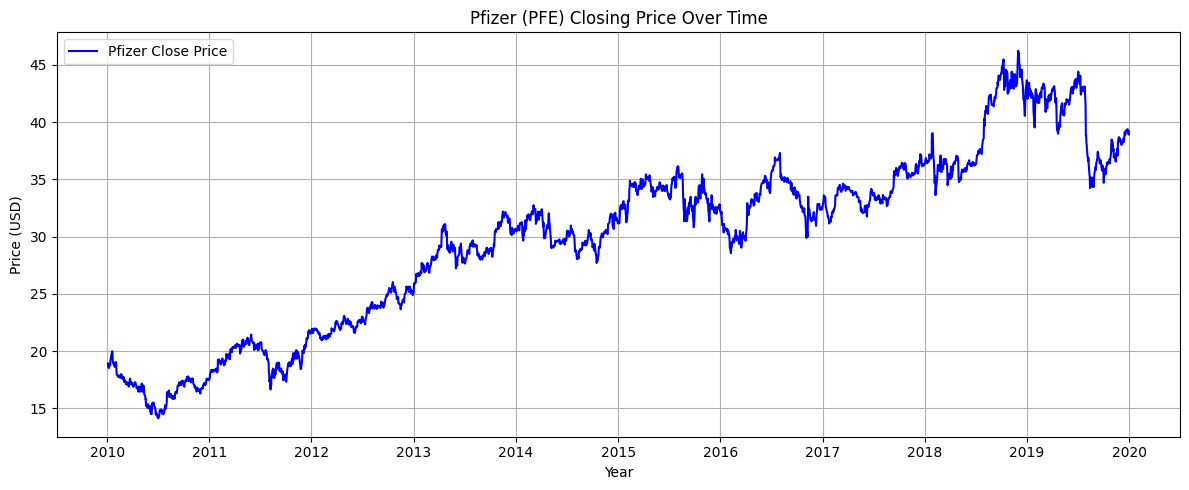

In [158]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your cleaned data (with datetime index)
df = pd.read_csv("data/train_data.csv", parse_dates=["date"])
df.set_index("date", inplace=True)
df.sort_index(inplace=True)

# Plot closing price
plt.figure(figsize=(12, 5))
plt.plot(df.index, df["close"], color="blue", label="Pfizer Close Price")
plt.title("Pfizer (PFE) Closing Price Over Time")
plt.xlabel("Year")
plt.ylabel("Price (USD)")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()


Training Logistic Regression on train data

In [160]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.metrics import classification_report
from itertools import combinations

# Load Data
train_data = pd.read_csv("data/train_data.csv", index_col=0, parse_dates=True)

# === Feature Engineering ===
window = 10

train_data["return"] = train_data["close"].pct_change()
train_data["log_return"] = np.log(train_data["close"] / train_data["close"].shift(1))
train_data["rolling_mean"] = train_data["close"].rolling(window).mean()
train_data["rolling_std"] = train_data["close"].rolling(window).std()
train_data["volatility"] = train_data["return"].rolling(window).std()
train_data["ema"] = train_data["close"].ewm(span=window, adjust=False).mean()
train_data["price_dev"] = train_data["close"] - train_data["rolling_mean"]

# Compute RSI (Relative Strength Index) - No-lag momentum feature
delta = train_data["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

avg_gain = pd.Series(gain, index=train_data.index).rolling(window=window, min_periods=window).mean()
avg_loss = pd.Series(loss, index=train_data.index).rolling(window=window, min_periods=window).mean()

rs = avg_gain / (avg_loss + 1e-10)  # Add epsilon to avoid division by zero
train_data["rsi"] = 100 - (100 / (1 + rs))

train_data = train_data.dropna()

# === Target Variable ===
train_data["target"] = np.where(train_data["return"].shift(-1) > 0, 1, 0)  # 1 for long, 0 for short

# === Rolling Normalization ===
features = ["rolling_std", "log_return", "ema", "price_dev","rsi" ]
for f in features:
    train_data[f + "_norm"] = (
        train_data[f] - train_data[f].rolling(window).mean()
    ) / train_data[f].rolling(window).std()

# Drop rows with NaNs after normalization
train_data = train_data.dropna()

# === Add Squared Terms ===
for f in features:
    norm_col = f + "_norm"
    train_data[norm_col + "_squared"] = train_data[norm_col] ** 2

# === Add Interaction Features (pairwise products of normalized features) ===
norm_features = [f + "_norm" for f in features]
for f1, f2 in combinations(norm_features, 2):
    inter_col = f"{f1}_x_{f2}"
    train_data[inter_col] = train_data[f1] * train_data[f2]

# === Final Feature Set ===
squared_cols = [f + "_norm_squared" for f in features]
interaction_cols = [f"{f1}_x_{f2}" for f1, f2 in combinations(norm_features, 2)]
feature_cols = norm_features + squared_cols + interaction_cols

X = train_data[feature_cols]
y = train_data["target"]

# === Scale Features ===
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# === Train Logistic Regression ===
model = LogisticRegression(penalty='l2', C=1.0)
model.fit(X_scaled, y)

probs = model.predict_proba(X_scaled)[:, 1]

# === Predict In-Sample ===
# train_data["signal"] = model.predict(X_scaled)
train_data["signal"] = np.where(probs > 0.5, 1, 
                         np.where(probs < 0.5, -1, 1))

# === Classification Report ===
print("\nClassification Report (In-sample):")
print(classification_report(y, train_data["signal"]))





Classification Report (In-sample):
              precision    recall  f1-score   support

          -1       0.00      0.00      0.00         0
           0       0.00      0.00      0.00      1246
           1       0.53      0.55      0.54      1251

    accuracy                           0.28      2497
   macro avg       0.18      0.18      0.18      2497
weighted avg       0.27      0.28      0.27      2497



C:\Users\TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
C:\Users\TUF\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sklearn\metrics\_classification.py:1531: Un


 Strategy Performance Metrics:
---------------------------------
Total Return (%)              : 170.8086
Average Daily Return (%)      : 0.0684
Volatility (Std Dev %)        : 1.1534
Sharpe Ratio                  : 0.9419
Sortino Ratio                 : 1.4312
Max Drawdown (%)              : -23.4737
Average Drawdown (%)          : -7.2857
Risk-to-Reward Ratio          : 0.0094
Benchmark Total Return (%)    : 90.1241
Benchmark Max Drawdown (%)    : -25.9355


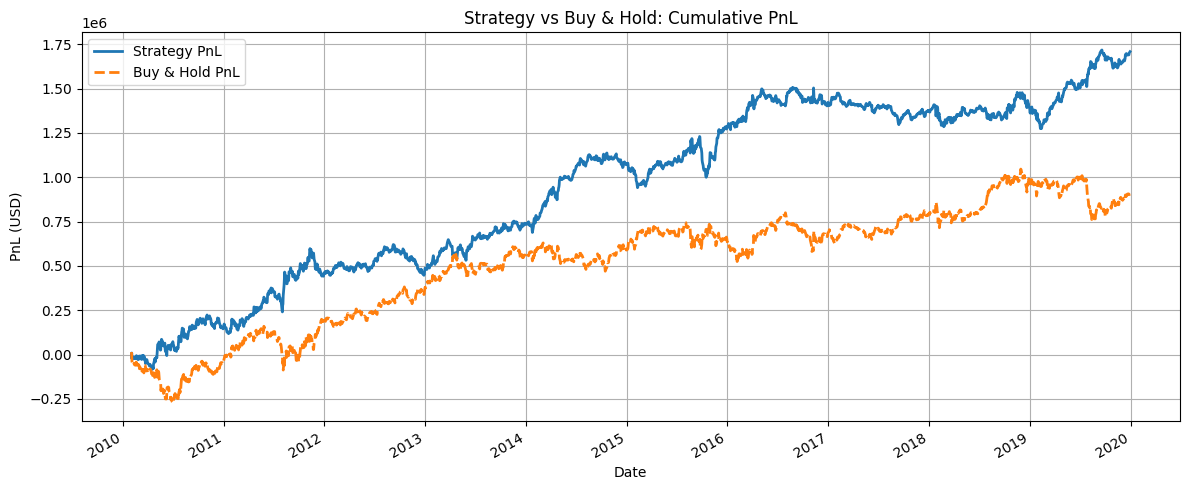

In [161]:
# Convert 0 to -1 for shorting
# train_data["signal"] = train_data["signal"].map({0: -1, 1: 1})

bt = backtest_strategy(train_data)
compute_metrics(bt)
plot_backtest(bt)


In [162]:
import pandas as pd
import numpy as np
from itertools import combinations

# === Step 1: Load Validation Data ===
validation_data = pd.read_csv("data/validation_data.csv", index_col=0, parse_dates=True)

# === Step 2: Feature Engineering ===
window = 10  # Same window as training

validation_data["return"] = validation_data["close"].pct_change()
validation_data["log_return"] = np.log(validation_data["close"] / validation_data["close"].shift(1))
validation_data["rolling_mean"] = validation_data["close"].rolling(window).mean()
validation_data["rolling_std"] = validation_data["close"].rolling(window).std()
validation_data["volatility"] = validation_data["return"].rolling(window).std()
validation_data["ema"] = validation_data["close"].ewm(span=window, adjust=False).mean()
validation_data["price_dev"] = validation_data["close"] - validation_data["rolling_mean"]
# Compute RSI (Relative Strength Index) - No-lag momentum feature
delta = validation_data["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

avg_gain = pd.Series(gain, index=validation_data.index).rolling(window=window, min_periods=window).mean()
avg_loss = pd.Series(loss, index=validation_data.index).rolling(window=window, min_periods=window).mean()

rs = avg_gain / (avg_loss + 1e-10)  # Add epsilon to avoid division by zero
validation_data["rsi"] = 100 - (100 / (1 + rs))







validation_data = validation_data.dropna()

# === Step 3: Rolling Normalization ===
features = ["rolling_std", "log_return", "ema", "price_dev", "rsi"]
for f in features:
    validation_data[f + "_norm"] = (
        validation_data[f] - validation_data[f].rolling(window).mean()
    ) / validation_data[f].rolling(window).std()
    validation_data[f + "_norm_squared"] = validation_data[f + "_norm"] ** 2

validation_data = validation_data.dropna()

# === Step 4: Add Interaction Features ===
norm_features = [f + "_norm" for f in features]
for f1, f2 in combinations(norm_features, 2):
    validation_data[f"{f1}_x_{f2}"] = validation_data[f1] * validation_data[f2]

# === Step 5: Prepare Feature Columns for Prediction ===
squared_cols = [f + "_norm_squared" for f in features]
interaction_cols = [f"{f1}_x_{f2}" for f1, f2 in combinations(norm_features, 2)]
feature_cols = norm_features + squared_cols + interaction_cols

X_val = validation_data[feature_cols]

# === Step 6: Scale & Predict ===
X_val_scaled = scaler.transform(X_val)


# validation_data["signal"] = model.predict(X_val_scaled)

probs = model.predict_proba(X_val_scaled)[:, 1]

# === Predict In-Sample ===
# train_data["signal"] = model.predict(X_scaled)
validation_data["signal"] = np.where(probs > 0.5, 1, 
                         np.where(probs < 0.5, -1, 1))

# === Step 7: Save or Use Predictions ===
validation_data.to_csv("signals/validation_with_signals.csv")



 Strategy Performance Metrics:
---------------------------------
Total Return (%)              : 78.2890
Average Daily Return (%)      : 0.1614
Volatility (Std Dev %)        : 2.0017
Sharpe Ratio                  : 1.2802
Sortino Ratio                 : 1.6853
Max Drawdown (%)              : -22.4467
Average Drawdown (%)          : -6.1328
Risk-to-Reward Ratio          : 0.0263
Benchmark Total Return (%)    : 56.2514
Benchmark Max Drawdown (%)    : -25.5358


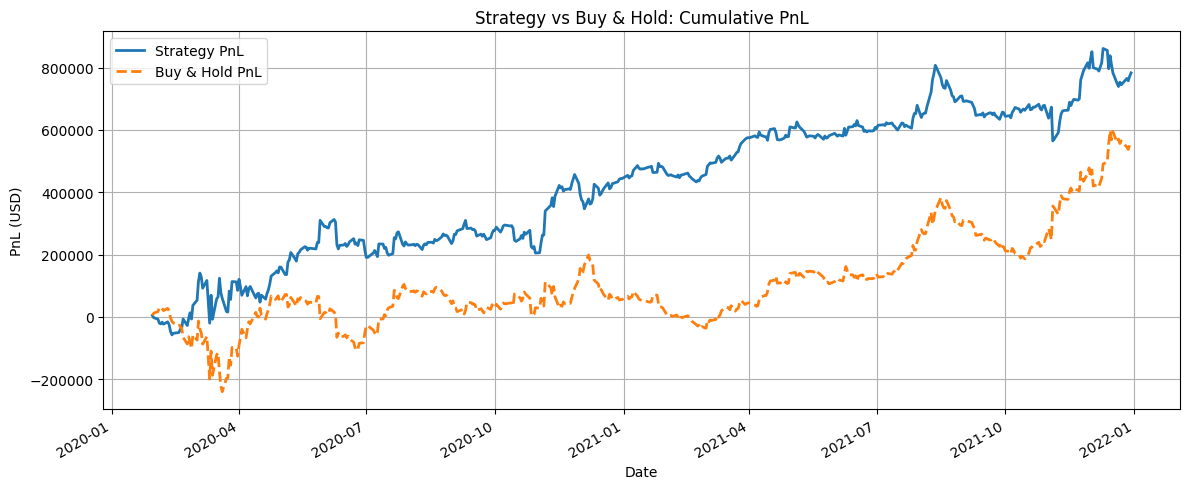

In [163]:
# Convert 0 to -1 for shorting
# validation_data["signal"] = validation_data["signal"].map({0: -1, 1: 1})
bt = backtest_strategy(validation_data)
compute_metrics(bt)
plot_backtest(bt)


Predicting on Test data


In [164]:
import pandas as pd
import numpy as np
from itertools import combinations

# === Step 1: Load Test Data ===
test_data = pd.read_csv("data/test_data.csv", index_col=0, parse_dates=True)

# === Step 2: Feature Engineering ===
window = 10  # Must match training

test_data["return"] = test_data["close"].pct_change()
test_data["log_return"] = np.log(test_data["close"] / test_data["close"].shift(1))
test_data["rolling_mean"] = test_data["close"].rolling(window).mean()
test_data["rolling_std"] = test_data["close"].rolling(window).std()
test_data["volatility"] = test_data["return"].rolling(window).std()
test_data["momentum"] = test_data["close"] / test_data["close"].shift(window) - 1
test_data["ema"] = test_data["close"].ewm(span=window, adjust=False).mean()
test_data["price_dev"] = test_data["close"] - test_data["rolling_mean"]

# Compute RSI (Relative Strength Index) - No-lag momentum feature
delta = test_data["close"].diff()
gain = np.where(delta > 0, delta, 0)
loss = np.where(delta < 0, -delta, 0)

avg_gain = pd.Series(gain, index=test_data.index).rolling(window=window, min_periods=window).mean()
avg_loss = pd.Series(loss, index=test_data.index).rolling(window=window, min_periods=window).mean()

rs = avg_gain / (avg_loss + 1e-10)  # Add epsilon to avoid division by zero
test_data["rsi"] = 100 - (100 / (1 + rs))




test_data = test_data.dropna()

# === Step 3: Rolling Normalization ===
features = ["rolling_std", "log_return", "ema", "price_dev", "rsi"]
for f in features:
    test_data[f + "_norm"] = (
        test_data[f] - test_data[f].rolling(window).mean()
    ) / test_data[f].rolling(window).std()
    test_data[f + "_norm_squared"] = test_data[f + "_norm"] ** 2

test_data = test_data.dropna()

# === Step 4: Add Interaction Features ===
norm_features = [f + "_norm" for f in features]
for f1, f2 in combinations(norm_features, 2):
    test_data[f"{f1}_x_{f2}"] = test_data[f1] * test_data[f2]

# === Step 5: Prepare Features for Prediction ===
squared_cols = [f + "_norm_squared" for f in features]
interaction_cols = [f"{f1}_x_{f2}" for f1, f2 in combinations(norm_features, 2)]
feature_cols = norm_features + squared_cols + interaction_cols

X_test = test_data[feature_cols]

# === Step 6: Scale & Predict ===
X_test_scaled = scaler.transform(X_test)
probs = model.predict_proba(X_test_scaled)[:, 1]

# Use custom threshold for signal
test_data["signal"] = np.where(probs > 0.5, 1, 
                        np.where(probs < 0.5, -1, 1))  # 0 = no position

# === Step 7: Save or Use Predictions ===
test_data.to_csv("signals/test_with_signals.csv")



 Strategy Performance Metrics:
---------------------------------
Total Return (%)              : -0.5233
Average Daily Return (%)      : -0.0007
Volatility (Std Dev %)        : 1.5434
Sharpe Ratio                  : -0.0067
Sortino Ratio                 : -0.0104
Max Drawdown (%)              : -43.9341
Average Drawdown (%)          : -26.6441
Risk-to-Reward Ratio          : -0.0000
Benchmark Total Return (%)    : -77.5681
Benchmark Max Drawdown (%)    : -60.8664


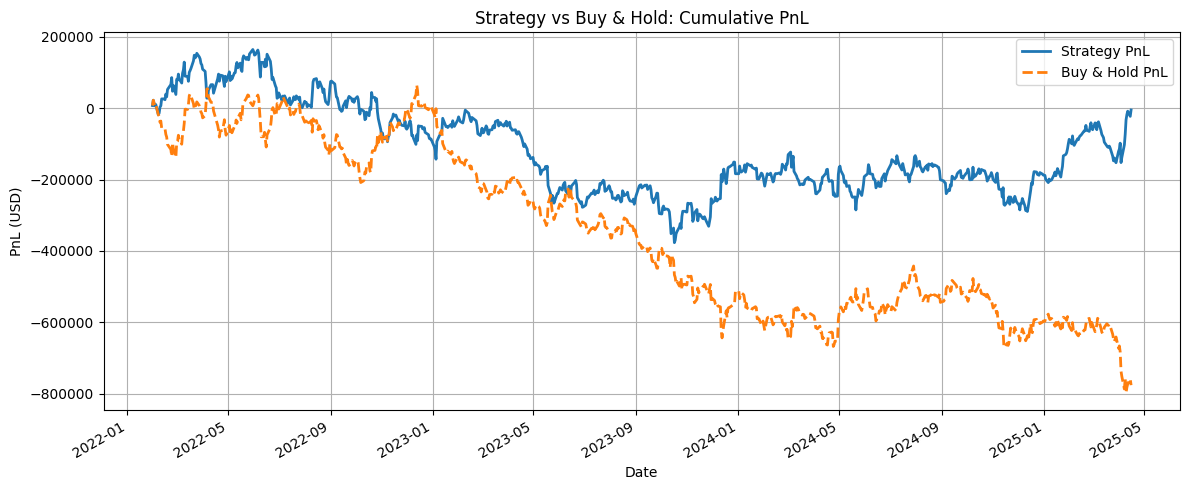

In [166]:
# Convert 0 to -1 for shorting
# validation_data["signal"] = validation_data["signal"].map({0: -1, 1: 1})
bt = backtest_strategy(test_data)
compute_metrics(bt)
plot_backtest(bt)
